# Stocks Price Prediction

In [451]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [452]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [453]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
print(start)

2005-09-11 00:00:00


In [454]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_8497/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2005-09-12,7.662150,7.703709,7.445946,7.464499,417017246
2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262
2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579
2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845
2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438


In [455]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [456]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2005-09-12,7.662150,7.703709,7.445946,7.464499,417017246
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975


In [457]:
data.shape

(5031, 6)

In [458]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [459]:
data.duplicated().sum()

np.int64(0)

In [460]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5031 non-null   object 
 1   Close   5031 non-null   float64
 2   High    5031 non-null   float64
 3   Low     5031 non-null   float64
 4   Open    5031 non-null   float64
 5   Volume  5031 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.0+ KB


In [461]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
5021,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
5022,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
5023,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
5024,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
5025,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
5026,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
5027,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
5028,2025-09-08,234.160004,238.399994,233.729996,235.789993,23128800
5029,2025-09-09,239.940002,240.589996,233.380005,234.190002,22854800
5030,2025-09-10,239.559998,242.080002,238.110001,239.250000,19972500


In [462]:
data.describe()

,Close,High,Low,Open,Volume
count,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03
mean,54.407333,54.966773,53.826034,54.379173,9.435306e+07
std,51.586810,52.138116,51.010074,51.538383,1.183469e+08
min,6.368386,6.663503,6.117549,6.493804,1.584340e+05
25%,14.101532,14.217673,13.987742,14.102645,2.559160e+07
50%,31.582870,31.953335,31.144870,31.724901,4.388400e+07
75%,75.699715,77.553027,75.165869,75.765517,1.171374e+08
max,239.940002,242.080002,238.110001,239.250000,1.650833e+09


In [463]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2005-09-12,7.662150,7.703709,7.445946,7.464499,417017246
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975


In [464]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [465]:
# adding log returns and pct returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data['Pct_Returns'] = data['Close'].pct_change()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2005-09-12,7.662150,7.703709,7.445946,7.464499,417017246,NaN,NaN
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994,0.013471,0.013562
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245,0.012875,0.012958
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047,-0.001701,-0.001699
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975,0.012733,0.012814


In [466]:
data.isnull().sum()

Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
Log_Returns    1
Pct_Returns    1
dtype: int64

In [467]:
data.shape

(5031, 8)

In [468]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2005-09-12,7.662150,7.703709,7.445946,7.464499,417017246,NaN,NaN
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997


In [469]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994,0.013471,0.013562
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245,0.012875,0.012958
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047,-0.001701,-0.001699
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975,0.012733,0.012814
10,2005-09-26,7.774457,7.939455,7.731910,7.903587,397259466,-0.003430,-0.003425


In [470]:
data.shape

(5030, 8)

In [471]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [472]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    5030.000000
mean        0.000684
std         0.018860
min        -0.123401
25%        -0.007816
50%         0.000758
75%         0.009908
max         0.182251
Name: Log_Returns, dtype: float64

Skewness: 0.24317040128247752
Kurtosis: 7.999199831666817


In [473]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -27.533600037529453
p-value: 0.0
Critical Value 1%: -3.431652537323488
Critical Value 5%: -2.8621155812282546
Critical Value 10%: -2.5670763824860745


In [474]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263,NaN
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849,NaN
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254,NaN
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997,NaN
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959,NaN
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994,0.013471,0.013562,NaN
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245,0.012875,0.012958,NaN
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047,-0.001701,-0.001699,NaN
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975,0.012733,0.012814,NaN
10,2005-09-26,7.774457,7.939455,7.731910,7.903587,397259466,-0.003430,-0.003425,NaN


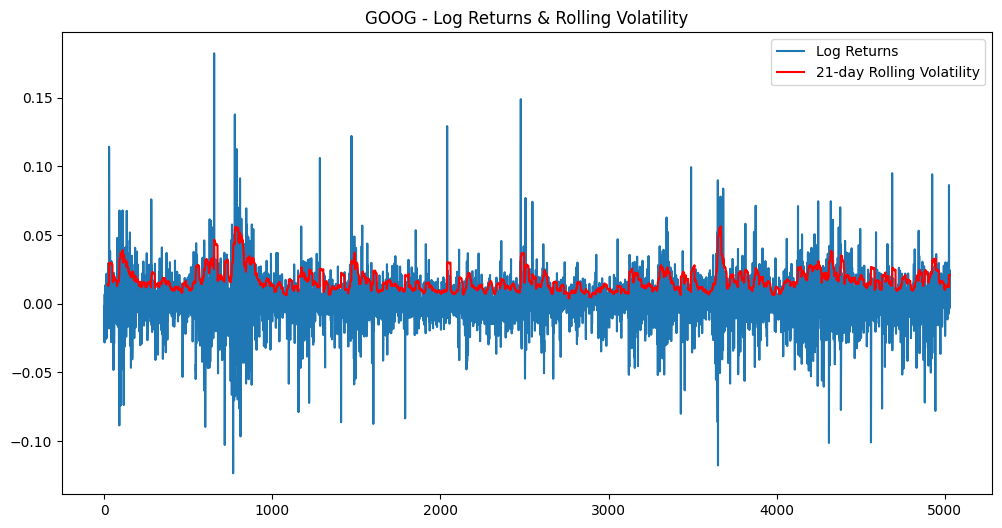

In [475]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

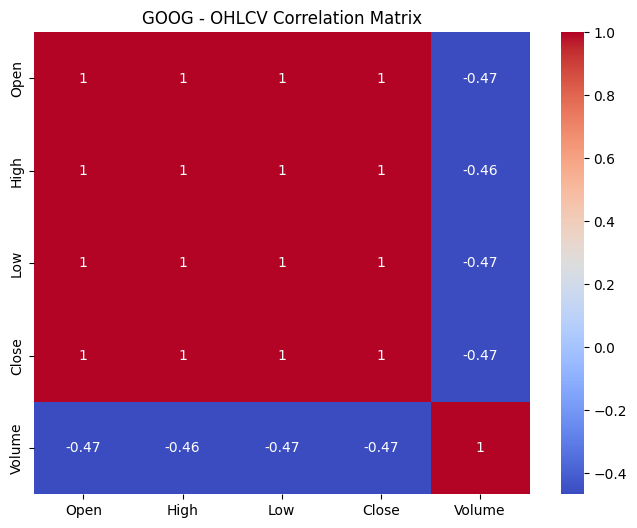

In [476]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()

In [477]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263,NaN
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849,NaN
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254,NaN
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997,NaN
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959,NaN
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994,0.013471,0.013562,NaN
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245,0.012875,0.012958,NaN
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047,-0.001701,-0.001699,NaN
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975,0.012733,0.012814,NaN
10,2005-09-26,7.774457,7.939455,7.731910,7.903587,397259466,-0.003430,-0.003425,NaN


In [478]:
data = data.drop("Rolling_Vol", axis=1)
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959


In [479]:
data.shape

(5030, 8)

### Remark:
    So far in my data i have added the Log_Returns and Pct_Returns features
    in a few i will be adding other features such as macd, bollinger, rsi, sma/ema features

In [480]:
# simple and exponential moving averages function
def add_moving_averages(data, windows=(5, 10, 20, 50, 200)):
    data = data.copy()
    for window in windows:
        # simple moving average
        data[f"SMA_{window}"] = data["Close"].rolling(window=window, min_periods=1).mean()
        
        # exponential moving average
        data[f"EMA_{window}"] = data["Close"].ewm(span=window, adjust=False).mean()
    
    return data

In [481]:
# relative strength index function
def add_rsi(data, period=14):
    data = data.copy()
    delta = data["Close"].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0)

    ma_up = up.ewm(alpha=1 / period, adjust=False).mean()
    ma_down = down.ewm(alpha=1 / period, adjust=False).mean()

    rs = ma_up / ma_down
    data[f"RSI_{period}"] = 100 - (100 / (1 + rs))

    return data

In [482]:
# moving average convergence divergence function
def add_macd(data, fast=12, slow=26, signal=9):
    data = data.copy()
    ema_fast = data["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = data["Close"].ewm(span=slow, adjust=False).mean()

    data["MACD"] = ema_fast - ema_slow
    data["MACD_Signal"] = data["MACD"].ewm(span=signal, adjust=False).mean()
    data["MACD_Hist"] = data["MACD"] - data["MACD_Signal"]

    return data

In [483]:
# bollinger bands function
def add_bollinger_bands(data, window=20, n_std=2):
    data = data.copy()

    sma = data["Close"].rolling(window=window).mean()
    rstd = data["Close"].rolling(window=window).std()

    data[f"BB_MID_{window}"] = sma
    data[f"BB_UP_{window}"] = sma + n_std * rstd
    data[f"BB_LOW_{window}"] = sma - n_std * rstd

    return data

In [484]:
# on-balance volume (obv)
def add_obv(data):
    data = data.copy()

    sign = np.sign(data["Close"].diff()).fillna(0)
    data["OBV"] = (sign * data["Volume"]).cumsum()

    return data

In [485]:
# vwap (daily rolling)
def add_vwap(data, window=14):
    data = data.copy()

    typical_price = (data["High"] + data["Low"] + data["Close"]) / 3
    vol = data["Volume"]
    vwap = (typical_price * vol).rolling(window=window).sum() / vol.rolling(window=window).sum()
    data[f"VWAP_{window}"] = vwap

    return data

In [486]:
# lags and rolling volatility
def add_lags_rollings(data, lag_list=(1, 2, 3, 4, 5), rolling_windows=(5, 10, 21)):
    data = data.copy()

    if "Log_Returns" not in data:
        data['Pct_Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    for l in lag_list:
        data[f'LogRet_lag_{l}'] = data['Log_Returns'].shift(l)

    for w in rolling_windows:
        data[f'RollMean_{w}'] = data['Log_Returns'].rolling(window=w).mean()
        data[f'RollVol_{w}'] = data['Log_Returns'].rolling(window=w).std()
    return data

In [487]:
# add all features
def add_all_features(data):
    data = data.copy()
    data = add_moving_averages(data)
    data = add_rsi(data)
    data = add_macd(data)
    data = add_bollinger_bands(data)
    data = add_obv(data)
    data = add_vwap(data)
    data = add_lags_rollings(data)
    data = data.dropna()
    return data

In [488]:
# adding all features
features = add_all_features(data)
print(features.head(10))

         Date     Close      High       Low      Open     Volume  Log_Returns  \
21 2005-10-11  7.572106  7.734135  7.541431  7.683671  342984790    -0.014755   
22 2005-10-12  7.445203  7.599069  7.396469  7.549842  373643277    -0.016901   
23 2005-10-13  7.357880  7.470682  7.190655  7.470682  424292413    -0.011798   
24 2005-10-14  7.325721  7.426898  7.236668  7.418734  342041267    -0.004380   
25 2005-10-17  7.544895  7.549843  7.286637  7.359365  303802474     0.029480   
26 2005-10-18  7.502347  7.618117  7.488988  7.543905  284173173    -0.005655   
27 2005-10-19  7.636424  7.665366  7.519168  7.520158  281479113     0.017714   
28 2005-10-20  7.500367  7.696535  7.451140  7.668335  558553779    -0.017977   
29 2005-10-21  8.408228  8.569764  8.237540  8.554178  919128253     0.114259   
30 2005-10-24  8.624681  8.640761  8.464878  8.494067  378682093     0.025417   

    Pct_Returns     SMA_5     EMA_5  ...  LogRet_lag_2  LogRet_lag_3  \
21    -0.014647  7.684413  7.669505 

In [489]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2005-09-13,7.710141,7.805379,7.573837,7.643844,413540262,0.006244,0.006263
2,2005-09-14,7.495420,7.749719,7.428629,7.637164,452722579,-0.028244,-0.027849
3,2005-09-15,7.486021,7.588185,7.369507,7.409334,620966845,-0.001255,-0.001254
4,2005-09-16,7.426155,7.532526,7.417992,7.520652,304328438,-0.008029,-0.007997
5,2005-09-19,7.514962,7.569632,7.438771,7.445945,231339881,0.011888,0.011959
6,2005-09-20,7.616881,7.700740,7.550585,7.573343,375441994,0.013471,0.013562
7,2005-09-21,7.715582,7.761595,7.568643,7.629249,406305245,0.012875,0.012958
8,2005-09-22,7.702472,7.896660,7.672787,7.705688,522206047,-0.001701,-0.001699
9,2005-09-23,7.801173,7.846937,7.732651,7.742794,340623975,0.012733,0.012814
10,2005-09-26,7.774457,7.939455,7.731910,7.903587,397259466,-0.003430,-0.003425


In [490]:
# adding all the features into the data
data = add_all_features(data)
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,SMA_5,EMA_5,...,LogRet_lag_2,LogRet_lag_3,LogRet_lag_4,LogRet_lag_5,RollMean_5,RollVol_5,RollMean_10,RollVol_10,RollMean_21,RollVol_21
21,2005-10-11,7.572106,7.734135,7.541431,7.683671,342984790,-0.014755,-0.014647,7.684413,7.669505,...,0.000767,0.006544,-0.000933,-0.024395,-0.003176,0.008183,-0.002529,0.015529,-0.000563,0.013778
22,2005-10-12,7.445203,7.599069,7.396469,7.549842,373643277,-0.016901,-0.016759,7.636225,7.594738,...,-0.007504,0.000767,0.006544,-0.000933,-0.006370,0.010003,-0.001657,0.014284,-0.001665,0.014128
23,2005-10-13,7.357880,7.470682,7.190655,7.470682,424292413,-0.011798,-0.011729,7.560479,7.515785,...,-0.014755,-0.007504,0.000767,0.006544,-0.010038,0.006993,-0.004013,0.013758,-0.000882,0.012991
24,2005-10-14,7.325721,7.426898,7.236668,7.418734,342041267,-0.004380,-0.004371,7.477114,7.452431,...,-0.016901,-0.014755,-0.007504,0.000767,-0.011068,0.005138,-0.006636,0.010360,-0.001031,0.013013
25,2005-10-17,7.544895,7.549843,7.286637,7.359365,303802474,0.029480,0.029918,7.449161,7.483252,...,-0.011798,-0.016901,-0.014755,-0.007504,-0.003671,0.019127,-0.004388,0.015033,0.000755,0.014495
26,2005-10-18,7.502347,7.618117,7.488988,7.543905,284173173,-0.005655,-0.005639,7.435209,7.489617,...,-0.004380,-0.011798,-0.016901,-0.014755,-0.001851,0.018220,-0.002514,0.013334,-0.000080,0.014326
27,2005-10-19,7.636424,7.665366,7.519168,7.520158,281479113,0.017714,0.017871,7.473453,7.538552,...,0.029480,-0.004380,-0.011798,-0.016901,0.005072,0.017639,-0.000649,0.014803,0.000122,0.014554
28,2005-10-20,7.500367,7.696535,7.451140,7.668335,558553779,-0.017977,-0.017817,7.501951,7.525824,...,-0.005655,0.029480,-0.004380,-0.011798,0.003836,0.019259,-0.003101,0.015494,-0.001347,0.014758
29,2005-10-21,8.408228,8.569764,8.237540,8.554178,919128253,0.114259,0.121042,7.718452,7.819959,...,0.017714,-0.005655,0.029480,-0.004380,0.027564,0.051948,0.008248,0.040319,0.004175,0.029224
30,2005-10-24,8.624681,8.640761,8.464878,8.494067,378682093,0.025417,0.025743,7.934409,8.088199,...,-0.017977,0.017714,-0.005655,0.029480,0.026751,0.051942,0.011540,0.040234,0.004779,0.029539


In [491]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns',
       'Pct_Returns', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'OBV',
       'VWAP_14', 'LogRet_lag_1', 'LogRet_lag_2', 'LogRet_lag_3',
       'LogRet_lag_4', 'LogRet_lag_5', 'RollMean_5', 'RollVol_5',
       'RollMean_10', 'RollVol_10', 'RollMean_21', 'RollVol_21'],
      dtype='object')

In [492]:
data = data.copy()

# next day target
data["Target_Close"] = data["Close"].shift(-1)

# next day log returns
data["Target_LogRet"] = data["Log_Returns"].shift(-1)

# next-day up/down (classification)
features["Target_Up"] = (features["Close"].shift(-1) > features["Close"]).astype(int)

# drop last row (NaN targets)
features = features.dropna()

In [493]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,SMA_5,EMA_5,...,LogRet_lag_4,LogRet_lag_5,RollMean_5,RollVol_5,RollMean_10,RollVol_10,RollMean_21,RollVol_21,Target_Close,Target_LogRet
21,2005-10-11,7.572106,7.734135,7.541431,7.683671,342984790,-0.014755,-0.014647,7.684413,7.669505,...,-0.000933,-0.024395,-0.003176,0.008183,-0.002529,0.015529,-0.000563,0.013778,7.445203,-0.016901
22,2005-10-12,7.445203,7.599069,7.396469,7.549842,373643277,-0.016901,-0.016759,7.636225,7.594738,...,0.006544,-0.000933,-0.006370,0.010003,-0.001657,0.014284,-0.001665,0.014128,7.357880,-0.011798
23,2005-10-13,7.357880,7.470682,7.190655,7.470682,424292413,-0.011798,-0.011729,7.560479,7.515785,...,0.000767,0.006544,-0.010038,0.006993,-0.004013,0.013758,-0.000882,0.012991,7.325721,-0.004380
24,2005-10-14,7.325721,7.426898,7.236668,7.418734,342041267,-0.004380,-0.004371,7.477114,7.452431,...,-0.007504,0.000767,-0.011068,0.005138,-0.006636,0.010360,-0.001031,0.013013,7.544895,0.029480
25,2005-10-17,7.544895,7.549843,7.286637,7.359365,303802474,0.029480,0.029918,7.449161,7.483252,...,-0.014755,-0.007504,-0.003671,0.019127,-0.004388,0.015033,0.000755,0.014495,7.502347,-0.005655


In [494]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns',
       'Pct_Returns', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'OBV',
       'VWAP_14', 'LogRet_lag_1', 'LogRet_lag_2', 'LogRet_lag_3',
       'LogRet_lag_4', 'LogRet_lag_5', 'RollMean_5', 'RollVol_5',
       'RollMean_10', 'RollVol_10', 'RollMean_21', 'RollVol_21',
       'Target_Close', 'Target_LogRet'],
      dtype='object')

In [495]:
data.shape

(5010, 40)

In [496]:
data.isnull().sum()

Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Log_Returns      0
Pct_Returns      0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
SMA_200          0
EMA_200          0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
BB_MID_20        0
BB_UP_20         0
BB_LOW_20        0
OBV              0
VWAP_14          0
LogRet_lag_1     0
LogRet_lag_2     0
LogRet_lag_3     0
LogRet_lag_4     0
LogRet_lag_5     0
RollMean_5       0
RollVol_5        0
RollMean_10      0
RollVol_10       0
RollMean_21      0
RollVol_21       0
Target_Close     1
Target_LogRet    1
dtype: int64

In [497]:
data.shape

(5010, 40)

In [498]:
data = data.dropna()
data.shape

(5009, 40)

In [499]:
data.isnull().sum()

Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Log_Returns      0
Pct_Returns      0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
SMA_200          0
EMA_200          0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
BB_MID_20        0
BB_UP_20         0
BB_LOW_20        0
OBV              0
VWAP_14          0
LogRet_lag_1     0
LogRet_lag_2     0
LogRet_lag_3     0
LogRet_lag_4     0
LogRet_lag_5     0
RollMean_5       0
RollVol_5        0
RollMean_10      0
RollVol_10       0
RollMean_21      0
RollVol_21       0
Target_Close     0
Target_LogRet    0
dtype: int64

In [520]:
X_cols = [col for col in data.columns if col not in ["Date", "Target_Close", "Target_LogRet"]]

In [521]:
X_raw = data[X_cols].values
y_raw = np.log(data['Target_Close']).diff().shift(-1).dropna().values
X_raw = X_raw[1:]

In [522]:
print(y_raw)

[-0.01179805 -0.00438025  0.02947952 ... -0.00341059  0.02438424
 -0.00158501]


In [523]:
train_size = int(0.8 * len(X_raw))
X_train_raw, X_test_raw = X_raw[:train_size], X_raw[train_size:]
y_train_raw, y_test_raw = y_raw[:train_size], y_raw[train_size:]

In [524]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

In [525]:
# creating sequences
T = 50

def create_sequences(X, y, T):
    sequences, targets = [], []
    for i in range(T, len(X)):
        sequences.append(X[i-T:i, :])
        targets.append(y[i])
    return np.array(sequences), np.array(targets)

X_train, y_train = create_sequences(X_train_scaled, y_train_raw, T)
X_test, y_test   = create_sequences(X_test_scaled, y_test_raw, T)


In [526]:
print(X_train.shape, X_test.shape)

(3956, 50, 37) (952, 50, 37)


In [527]:
print(y_train.shape, y_test.shape)

(3956,) (952,)


In [528]:
# scaling the targets
target_scaler = MinMaxScaler(feature_range=(0,1))
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = target_scaler.transform(y_test.reshape(-1,1))

In [530]:
# building the model
num_of_features = X_train.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(T, num_of_features)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [535]:
# compiling the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001
)
model.compile(
    optimizer = optimizer,
    loss = "mse",
    metrics=["mae"]
)

In [536]:
# model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 128)        │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,513 (533.25 KB)

 Trainable params: 136,513 (533.25 KB)

 Non-trainable params: 0 (0.00 B)

In [537]:
# early stopping strategy
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [ ]:
history = model.fit(
    X_train,
    y_train_scaled,
    validation_data = (X_test, y_test_scaled),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/50


2025-09-11 13:05:05.047261: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29274400 exceeds 10% of free system memory.


124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - loss: 0.0197 - mae: 0.1038 - val_loss: 0.0064 - val_mae: 0.0624
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 0.0060 - mae: 0.0566 - val_loss: 0.0062 - val_mae: 0.0608
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 0.0051 - mae: 0.0508 - val_loss: 0.0046 - val_mae: 0.0498
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 0.0044 - mae: 0.0472 - val_loss: 0.0048 - val_mae: 0.0512
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - loss: 0.0041 - mae: 0.0453 - val_loss: 0.0047 - val_mae: 0.0510
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - loss: 0.0041 - mae: 0.0444 - val_loss: 0.0052 - val_mae: 0.0550
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 0.0040 - mae: 0.0448 - val_loss: 0.0049 - val_mae: 0.0524
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 0.0045 - mae: 0.0452 - val_loss: 0.0046 - val_mae: 0.0495
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s

In [539]:
best_val_loss = min(history.history["val_loss"])
print(best_val_loss)

0.004562246613204479


In [542]:
# making predictions
y_pred_scaled = model.predict(X_test)
y_pred_logreturn = target_scaler.inverse_transform(y_pred_scaled).flatten()

last_train_price = data['Target_Close'].iloc[train_size + T - 1]  # last price before test sequence
y_pred_price = [last_train_price]

for r in y_pred_logreturn:
    y_pred_price.append(y_pred_price[-1] * np.exp(r))

# remove first seed price to align with y_test
y_pred_price = np.array(y_pred_price[1:])
y_test_price = data['Target_Close'].iloc[train_size + T:].values
y_test_price = y_test_price[:len(y_pred_price)]

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [543]:
mse  = mean_squared_error(y_test_price, y_pred_price)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_price, y_pred_price)
r2   = r2_score(y_test_price, y_pred_price)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 10285.0709
RMSE: 101.4153
MAE: 85.1787
R²: -9.2255


In [519]:
# for actual, pred in zip(y_test[:10], y_pred[:10]):
#     print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")